In [1]:
### Data handling imports
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
import os
import itertools
import collections
import tweepy
import nltk
from nltk.corpus import stopwords
import re

# import networkx
from textblob import TextBlob
import pandas as pd
import math
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import json
import warnings
from collections import defaultdict
from sklearn.cluster import KMeans
import textwrap
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter

warnings.filterwarnings("ignore")
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
pd.set_option("display.width", 1000)
pd.options.display.max_rows
pd.set_option("display.max_colwidth", -1)
# from utils.text_wapper import remove_url

## Overview
The PBL final used a back propagation neural network to fit the data from the previous section (a virtual species dataset with different variables and covariables). 

In our proposed research, we can try back propagation (BP) mode first, then find some different binary models. Assume other models will be better than the traditional BP model, we should use the same evaluation method to compare their accuracy. 

Since our data is unstructured text based, location based data. We might not directly use the BP network to fit into our data. Here is the dimension of the data that we got:

### Tweets

In [2]:
sample_path_1 = "twitter-demographics/twittes-with-geocoding-cleaned.csv"
sample_df_1 = pd.read_csv(sample_path_1)
sample_df_1.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256449 entries, 0 to 256448
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   created_at               256449 non-null  object 
 1   id                       256449 non-null  int64  
 2   id_str                   256449 non-null  int64  
 3   text                     256449 non-null  object 
 4   truncated                256449 non-null  bool   
 5   geo                      256449 non-null  object 
 6   place                    255980 non-null  object 
 7   quote_count              256449 non-null  float64
 8   reply_count              256449 non-null  float64
 9   retweet_count            256449 non-null  float64
 10  favorite_count           256449 non-null  float64
 11  entities                 256449 non-null  object 
 12  lang                     256449 non-null  object 
 13  timestamp_ms             256449 non-null  object 
 14  user

### Census
Each tweets data show above is a row, and it contains CountyId columns as a index of census data. The head of census data shows below: 

In [3]:
sample_path_2 = "us-census/tract_2017.csv"
sample_df_2 = pd.read_csv(sample_path_2)
sample_df_2.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CountyId          3219 non-null   int64  
 1   State             3219 non-null   object 
 2   County            3219 non-null   object 
 3   TotalPop          3219 non-null   int64  
 4   Men               3219 non-null   int64  
 5   Women             3219 non-null   int64  
 6   Hispanic          3219 non-null   float64
 7   White             3219 non-null   float64
 8   Black             3219 non-null   float64
 9   Native            3219 non-null   float64
 10  Asian             3219 non-null   float64
 11  Pacific           3219 non-null   float64
 12  VotingAgeCitizen  3219 non-null   int64  
 13  Income            3219 non-null   int64  
 14  IncomeErr         3219 non-null   int64  
 15  IncomePerCap      3219 non-null   int64  
 16  IncomePerCapErr   3219 non-null   int64  


the shape of the two dataset is:

In [4]:
print(sample_df_1.shape, sample_df_2.shape)

(256449, 39) (3219, 37)


In [5]:
# then if we put those two different dataset together, the final shape will be.
final_shape = 39 + 37
print(256449, final_shape)

256449 76


## Encoding
Some of the columns store in float or double value, others is string value. Those string value is required to be encoded so that the binary model can read those data. Before getting into encoding, some of the data variables might be cleared:

+ binary data: like true or false, 1 or 0: e.g. gender
+ categorical data: is a variable that can take some limited number of avalues. e.g., race: 1: nh_white, 2: nh_black ...
+ Ordinal data: float, double or rating that are given to a move by users 
+ Nominal data: is a variable that has no particular numerical importance, such as ossupation, username
+ timeseries data: as its name suggests

### Feature hashing
Feature hashing is used to represent categories in a "one hot encoding style" as a sparse martirx but with a much lower dimension. In feature hashing we apply a hashing function to category and then represent it by its indices. e.g. if we use a dimension of 5 to represent "New York" we will caculate H(New York) mode 5 = 3 (just example) so New York representattion will be (0,0,0,1,0)

In [6]:
from sklearn.feature_extraction import FeatureHasher
import tensorflow as tf

print(tf.__version__)
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

2.2.0-rc2
tf.Tensor(312.63388, shape=(), dtype=float32)


In [7]:
# import covid twitter data
covid_tweets_data_path = "/scratch/user/diya.li/kaggle-data/covid-twitter/"
hashtags_df = pd.read_csv(covid_tweets_data_path + "Hashtags.CSV")

# country code set
countries_code_df = pd.read_csv(covid_tweets_data_path + "Countries.CSV").dropna()
countries_code_set = [
    {country: country_code}
    for country, country_code in zip(
        countries_code_df.country, countries_code_df.country_code
    )
]

In [8]:
# tweets content
tweets_df = pd.DataFrame()
for file in os.listdir(covid_tweets_data_path):
    if file.startswith("2020"):
        tweets_df = tweets_df.append(pd.read_csv(covid_tweets_data_path + file))

In [9]:
tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1238615829341560832,1072590021201420294,2020-03-14T00:00:00Z,YalePediatrics,Calling #COVID19 the “Wuhan Virus” or “China Virus” is inaccurate and xenophobic https://t.co/0f0KRkcDj4,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,512,1456,NaN,2018-12-11T20:32:43Z,False,en
1,1238615828527972353,78720160,2020-03-14T00:00:00Z,MatrizOpinion,Así se detiene el mundo por el coronavirus\n\nEntra en nuestro link https://t.co/yCCalZuFXp y entérate de cuáles son las medidas tomadas mundialmente para evitar la propagación del virus.\n\n#Virus #13Mar #COVID19 https://t.co/xrFxoorq9z,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,23818,26341,NaN,2009-09-30T22:02:42Z,False,es
2,1238615827370455040,45013575,2020-03-14T00:00:00Z,teleSURtv,"Lo primero que hay que hacer es: \n\n✅NO entrar en pánico 👈🏾\n\nY, en segundo lugar tomar las medidas correspondientes para evitar un posible contagio\n\nPrepararse activamente y conocer todo sobre el #Covid19 será nuestra mejor arma de combate😷 https://t.co/BjTsv32d0G https://t.co/ihHSKQQvBz",TweetDeck,NaN,NaN,NaN,False,...,12,NaN,NaN,NaN,1830811,287,NaN,2009-06-05T22:21:49Z,True,es
3,1238615828691668992,15872418,2020-03-14T00:00:00Z,ABSCBNNews,The World Health Organization has declared Europe as the 'epicenter' of the #COVID19 pandemic after it recorded the highest number of cases and deaths than the rest of the world combined aside from China. https://t.co/G7XxTpuy4h,TweetDeck,NaN,NaN,NaN,False,...,272,NaN,NaN,NaN,6705845,1075,NaN,2008-08-16T10:09:33Z,True,en
4,1238615830360756227,38277042,2020-03-14T00:00:00Z,889Noticias,"En unos minutos, @889romo te comenta en @889Noticias, de las recomendaciones para prevenir casos de #COVID19 y las medidas a seguir en el transporte público, escucha a través de #internet https://t.co/JqJiUMCbf8 vg",TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,262080,164,NaN,2009-05-06T21:09:11Z,True,es


In [14]:
filter_fear = ["panic", "fear", "terrible", "afraid", "bad"]
filter_fear_rg = "|".join(filter_fear)
# filter_heart = ["heart disease"]
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [124]:
tweets_df.to_csv("./depression/covid-tweets.csv", index=False)

In [11]:
tweets_df.shape

(8219548, 22)

In [13]:
tweets_df = tweets_df.drop(['source', 'reply_to_status_id', 'reply_to_user_id', 'account_created_at'], axis=1)

In [15]:
filter_fear_rg

'panic|fear|terrible|afraid|bad'

In [17]:
df_fear = tweets_df[tweets_df['text'].str.contains(filter_fear_rg, case=False, regex=True)]

In [20]:
df_fear.to_csv("twitter-covid-fear.csv", index=False)

In [34]:
filter_result_fear = []
filter_result_heart = []
for index, sentence in enumerate(tweets_df["text"]):
    sentence_token = word_tokenize(sentence)
    for token in sentence_token:
        if token in filter_fear:
            filter_result_fear.append(sentence)
        if token in filter_result_heart:
            filter_result_heart.append(sentence)
    if index % 100000 == 0:
        print(index)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000


In [37]:
len(filter_result_fear)

120262

In [38]:
df = pd.DataFrame()
df["text"] = filter_result_fear

In [67]:
df_output = pd.DataFrame(filter_result_fear, columns=["text"])
df_output.to_csv("./depression/fear_text.csv", index=False)

In [39]:
# removing URLs
url_pattern = re.compile(
    "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
)
pic_pattern = re.compile("pic\.twitter\.com/.{10}")
keyword_pattern = re.compile("(covid|-19|_19|\d+)")
df["clean_text"] = df["text"].apply(lambda buf: url_pattern.sub("", buf))
df["clean_text"] = df["clean_text"].apply(lambda buf: pic_pattern.sub("", buf))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("@ ", "@"))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("# ", "#"))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("@", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("#", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("coronavirus", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("Coronavirus", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("covid19", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("covid-19", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("COVID", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("Covid-19", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("COVID-19", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("COVID19", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("virus", ""))
df["clean_text"] = df["clean_text"].apply(lambda buf: buf.replace("Covid19", ""))

df.head()

,text,clean_text
0,“Fear of the unknown is the greatest fear of a...,“Fear of the unknown is the greatest fear of a...
1,"📣 New Podcast! ""COVID-19 Update Day One"" on @S...","📣 New Podcast! ""-19 Update Day One"" on Spreake..."
2,Just watching the news. The message overall is...,Just watching the news. The message overall is...
3,We break the power of the spirit of fear in yo...,We break the power of the spirit of fear in yo...
4,We break the power of the spirit of fear in yo...,We break the power of the spirit of fear in yo...


In [43]:
# df_temp = df.groupby('user_id', as_index=False).agg(sum)
# df_temp.head()
df_temp = df

In [54]:
## Tweet term frequency using TweetTokenizer
tweets_df = df_temp

tweet_tokenizer = TweetTokenizer()
punct = list(string.punctuation)
stopwords_list = (
    stopwords.words("english") + punct + ["rt", "via", "...", "…", "’", "—", "—:", "“"]
)
term_frequency = Counter()


def process_tweets_tokens(text, tokenizer=TweetTokenizer(), stopwords=stopwords_list):
    """ Process the text of a tweet
        - Lowercase
        - Tokenize
        - Stopword removal
        - Digits removal """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [tok for tok in tokens if tok not in stopwords and not tok.isdigit()]


def process_tweets(x):
    twtokens = process_tweets_tokens(
        x, tokenizer=tweet_tokenizer, stopwords=stopwords_list
    )
    return " ".join(twtokens)


for x in tweets_df.clean_text:
    tweet_tokens = process_tweets_tokens(
        x, tokenizer=tweet_tokenizer, stopwords=stopwords_list
    )
    term_frequency.update(tweet_tokens)

for tag, count in term_frequency.most_common(20):
    print("{}: {}".format(tag, count))

tweets_df["processed_tweets"] = tweets_df["clean_text"].apply(process_tweets)

# tweets_df[['text', 'clean_text', 'processed_tweets']].head()

## 6) WordCloud for most occuring words

# from collections import Counter
# # wordcloud in python
# from wordcloud import WordCloud, STOPWORDS

# import re
# import string
# import nltk # preprocessing text
# from textblob import TextBlob

# wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=100,colormap="Paired", background_color='black',)
# wordcloud.generate(str(tweets_df['processed_tweets']))
# # declare our figure
# plt.figure(figsize=(20,10))
# plt.title("Top words - tweets", fontsize=20,color='black')
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout(pad=10)
# plt.show()

panic: 55331
fear: 36451
bad: 35521
people: 24298
pandemic: 18769
covid: 17527
_19: 16866
outbreak: 11007
us: 10320
buying: 10157
get: 9932
afraid: 9722
like: 9359
need: 8938
time: 8144
terrible: 7157
going: 6750
one: 6490
stop: 6325
world: 6300


In [55]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, max_features=8000, stop_words="english")


def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)

    sse = []
    for k in iters:
        sse.append(
            MiniBatchKMeans(
                n_clusters=k, init_size=1024, batch_size=2048, random_state=20
            )
            .fit(data)
            .inertia_
        )
        print("Fit {} clusters".format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker="o")
    ax.set_xlabel("Cluster Centers")
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel("SSE")
    ax.set_title("SSE by Cluster Center Plot")


def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    pca = PCA(n_components=5).fit_transform(data[max_items, :].todense())
    tsne = TSNE().fit_transform(
        PCA(n_components=50).fit_transform(data[max_items, :].todense())
    )

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i / max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title("PCA Cluster Plot")

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title("TSNE Cluster Plot")


def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense).groupby(clusters).mean()

    for i, r in df.iterrows():
        print("\nCluster {}".format(i))
        print(",".join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [56]:
tfidf.fit(tweets_df.clean_text)
text = tfidf.transform(tweets_df.clean_text)

In [57]:
clusters = MiniBatchKMeans(
    n_clusters=5, init_size=1024, batch_size=2048, random_state=20
).fit_predict(text)

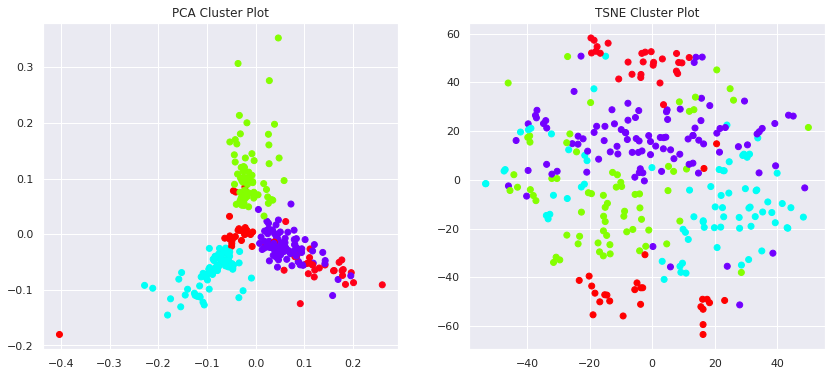

In [58]:
plot_tsne_pca(text, clusters)

In [69]:
import tensorflow as tf
import tensorflow_hub as hub

In [74]:
# import tensorflow_hub as hub
# import os

# os.environ["TFHUB_CACHE_DIR"] = "/scratch/user/diya.li/tmp/tfhub"
# hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

'94e2fa0c620704531d1d9b64c5e43e6c3c77e1d6'

In [112]:
export_dir = "../tmp/tfhub/063d866c06683311b44b4992fd46003be952409c"

In [113]:
data = df_temp["text"].tolist()
chunks = [data[x : x + 10000] for x in range(0, len(data), 10000)]
len(chunks)
df2 = df_temp.head(10000)

In [118]:
# Get word embeddings
cfg = tf.compat.v1.ConfigProto(allow_soft_placement=True )
cfg.gpu_options.allow_growth = True
with tf.Session(config=cfg) as session:
    embed = tf.saved_model.load(sess = session, export_dir = export_dir,tags = [""])
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"]))
#     message_embeddings = session.run(embed(list(user_tweets.values())))
print(message_embeddings.shape)

INFO:tensorflow:Restoring parameters from ../tmp/tfhub/539544f0a997d91c327c23285ea00c37588d92cc/variables/variables


INFO:tensorflow:Restoring parameters from ../tmp/tfhub/539544f0a997d91c327c23285ea00c37588d92cc/variables/variables


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Embeddings/sharded_0 not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-118-76bdb5c8eb5a>:5) ]]

Original stack trace for 'save/RestoreV2':
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/runpy.py", line 193, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
    self.do_execute(
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2857, in run_cell
    result = self._run_cell(
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3062, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-118-76bdb5c8eb5a>", line 5, in <module>
    tf.saved_model.load(sess = session, export_dir = export_dir,tags = [])
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/saved_model/loader_impl.py", line 299, in load
    return loader.load(sess, tags, import_scope, **saver_kwargs)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/saved_model/loader_impl.py", line 451, in load
    saver, _ = self.load_graph(sess.graph, tags, import_scope,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/saved_model/loader_impl.py", line 381, in load_graph
    return tf_saver._import_meta_graph_with_return_elements(  # pylint: disable=protected-access
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 1488, in _import_meta_graph_with_return_elements
    saver = _create_saver_from_imported_meta_graph(meta_graph_def, import_scope,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 1509, in _create_saver_from_imported_meta_graph
    return Saver()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 836, in __init__
    self.build()
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 848, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 876, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 515, in _build_internal
    restore_op = self._AddRestoreOps(filename_tensor, saveables,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 335, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/training/saver.py", line 583, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1503, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 742, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3319, in _create_op_internal
    ret = Operation(
  File "/scratch/user/diya.li/.conda/envs/jupyterlab_2.0.1/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()
